# Cartesian Kerr-Schild Geodesic Integrator for Naked Singularity

This program is adapted from Dr. Chi-Kwan Chan's [geodesic integrator](https://github.com/rndsrc/bhrad/blob/main/5.geodesic.ipynb) for non-spinning black holes.

In [1]:
# We will use JAX for autodiff

from jax import numpy as np
from jax import jacfwd
from jax import jit
from jax.numpy        import dot
from jax.numpy.linalg import inv

from matplotlib import pyplot as plt
import numpy.polynomial.polynomial as poly

from tqdm import tqdm

## 1. The Cartesian Kerr-Schild coordinates

Thanks to autodiff, we only need to implement the metric for the Kerr-Schild coordinates $g_{\mu\nu}$. All other functions, such as the inverse metric $g^{\mu\nu}$ and the Jacobian of the metric $g_{\mu\nu,\alpha}$, can be computed automatically using JAX.

The Cartesian Kerr-Schild metric is expressed as follow, for indices (1, 2, 3, 4) representing (t, x, y, z):

$g_{\mu\nu} = \eta_{\mu\nu} + fl_{\mu}l_{\nu}$ 

$\eta_{\mu\nu}$ = diag(-1, 1, 1, 1) (Minkowski tensor)

$f = \large{\frac{2r^3}{r^4 + a^4z^2}}$ (In dimensionless units, G = M = 1)

$\textbf{l} = (l_t, l_x, l_y, l_z) = (1, \large{\frac{rx+ay}{r^2+a^2}, \large{\frac{ry-ax}{r^2+a^2}}, \large{\frac{z}{r}}} \normalsize)$

r is implicitly defined by: $\large{\frac{x^2+y^2}{r^2+a^2}} \normalsize + \large{\frac{z^2}{r^2}}\normalsize = 1$

From the above equation, $r = \pm \frac{1}{\sqrt{2}} (\pm \sqrt{...})$. The only r that works for the Kerr-Schild metric is when both $\pm$ are pluses (written in full form in the code).

In [2]:
eta = np.asarray([[-1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]) # Minkowski tensor

def metric(m):
    a = 1.1
    x = m[1]
    y = m[2]
    z = m[3]
    r = (1/np.sqrt(2))*(np.sqrt(-a**2 + np.sqrt(a**4 - 2*a**2*x**2 - 2*a**2*y**2 + 2*a**2*z**2 + x**4 + 2*x**2*y**2 + 2*x**2*z**2 + y**4 + 2*y**2*z**2 + z**4) + x**2 + y**2 + z**2))
    f = (2*r**3)/(r**4+a**2*z**2)
    l = np.asarray([1, (r*x+a*y)/(r**2+a**2), (r*y-a*x)/(r**2+a**2), z/r])
    return eta + f * l[:,np.newaxis] * l[np.newaxis,:] 

def imetric(x):
    return inv(metric(x))

dmetric = jacfwd(metric)

## 2. Runge-Kutta-Fehlberg 4(5) method

Because the 4th-order Runge-Kutta method is unstable in integrating geodesics inside the event horizon due to large step sizes, the Runge-Kutta-Fehlberg 4(5) adaptive stepsize control with [Cash-Karp](https://dl.acm.org/doi/10.1145/79505.79507) parameters is implemented. For more reference on this method, read [Numerical Recipes for C](https://people.cs.clemson.edu/~dhouse/courses/817/papers/adaptive-h-c16-2.pdf).

In [3]:
def RKF45(rhs, state, dt, epsilon):
    
    t = state[0]
    k1 = dt * rhs(state, t)
    k2 = dt * rhs(state + 1/5 * k1, t + 1/5 * dt)
    k3 = dt * rhs(state + 3/40 * k1 + 9/40 * k2, t + 3/10 * dt)
    k4 = dt * rhs(state + 3/10 * k1 - 9/10 * k2 + 6/5 * k3, t + 3/5 * dt)
    k5 = dt * rhs(state - 11/54 * k1 + 5/2 * k2 - 70/27 * k3 + 35/27 * k4, t + dt)
    k6 = dt * rhs(state + 1631/55296 * k1 + 175/512 * k2 + 575/13824 * k3 + 44275/110592 * k4 + 253/4096 * k5, t + 7/8 * dt)
    
    # Embedded 4th order
    state4 = state + 2825/27643 * k1 + 18575/48384 * k3 + 13525/55296 * k4 - 277/14336 * k5 + 1/4 * k6
    
    # 5th order
    state5 = state + 37/378 * k1 + 250/621 * k3 + 125/594 * k4 + 512/1771 * k6
    
    R = np.linalg.norm(state5 - state4) # Truncation error
    
    multiplier = 0.9*(epsilon/R)**1/4 
    
    # If the truncation error is small, return the 4th order estimation and update the stepsize
    if R <= epsilon:
        dt = dt * multiplier
        return state4
    # If the truncation error is big, repeat the process with a smaller stepsize
    else:
        return RKF45(rhs, state, dt * multiplier, epsilon)

## 3. The Geodesic Equation

The geodesic equation is expressed in the form derived by this [paper](https://iopscience.iop.org/article/10.3847/1538-4357/aadfe5/meta).

In [4]:
def rhs(state, t):
    x  = np.append(t, state[1:4])
    v  = state[4:]
    
    ig = imetric(x)
    jg = dmetric(x)
    a  = (-       dot(ig, dot(dot(jg, v), v))
          + 0.5 * dot(ig, dot(v, dot(v, jg))))
    
    return np.concatenate([v, a])

## 4. Naked Singularity Experiment

In [5]:
import numpy as np_
def ring(array, N):
    theta_rad_array_xy = []
    theta_rad_array_xz = []
    theta_rad_array_yz = []
    
    for i in array:
        dt = 0.05 # Step size
        s0 = np.array([
            0, 10, 0, i,
            1, -1, 0, 0,
        ], dtype=np.float32) # Initial conditions

        # Construct the array to hold the results

        states = [s0]

        # Integrate the geodesic equation

        for j in tqdm(range(N)):
            states.append(RKF45(rhs, states[-1], dt, 0.1))

        S = np.array(states)
        X = S[:,:4]
        V = S[:,4:]
        
        filename_X = "Xz = "+str(i)+".csv"
        np_.savetxt(filename_X, X, delimiter=",")
        
        filename_V = "Vz = "+str(i)+".csv"
        np_.savetxt(filename_V, V, delimiter=",")
        
        # (vi \dot vf)/|vi||vf|=cos(theta)
        x_i = V[0, 1]
        y_i = V[0, 2]
        z_i = V[0, 3]
        x_f = V[N, 1]
        y_f = V[N, 2]
        z_f = V[N, 3]
        
        # xy
        dp_xy = x_i*x_f + y_i*y_f
        norm1_xy = np.linalg.norm(np.array([x_i, y_i]))
        norm2_xy = np.linalg.norm(np.array([x_f, y_f]))
        theta_rad_xy = np.arccos(dp_xy/(norm1_xy*norm2_xy))
        
        # xz
        dp_xz = x_i*x_f + z_i*z_f
        norm1_xz = np.linalg.norm(np.array([x_i, z_i]))
        norm2_xz = np.linalg.norm(np.array([x_f, z_f]))
        theta_rad_xz = np.arccos(dp_xz/(norm1_xz*norm2_xz))
        
        # yz
        dp_yz = y_i*y_f + z_i*z_f
        norm1_yz = np.linalg.norm(np.array([y_i, z_i]))
        norm2_yz = np.linalg.norm(np.array([y_f, z_f]))
        theta_rad_yz = np.arccos(dp_yz/(norm1_yz*norm2_yz))  
        
        #xyz
        dp = dot(V[N, 1:], V[0, 1:])
        norm1 = np.linalg.norm(V[N, 1:]) # final velocity (vf)
        norm2 = np.linalg.norm(V[0, 1:]) # initial velocity (vi)
        theta_rad_xyz = np.arccos(dp/(norm1*norm2))
        
        theta_rad_array_xy.append(theta_rad_xy)
        theta_rad_array_xz.append(theta_rad_xz)
        theta_rad_array_yz.append(theta_rad_yz)
        theta_rad_array_xyz.append(theta_rad_xyz)
        
        # 2d x-y plot
        fig, ax = plt.subplots(1,1,figsize=(16,8))
        a = 1.1
        ax.plot(X[:,1], X[:,3], color = "blue")

        ax.set_xlabel("x")
        ax.set_ylabel("z")
        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, i+5)
        plt.scatter(a,0, color="red")
        plt.scatter(-a,0, color="red")
        ax.set_aspect('equal')
        ax.set_title("z_initial = " + str(i))
        
    return(theta_rad_array_xy, theta_rad_array_xz, theta_rad_array_yz, theta_rad_array_xyz)

## 4.1. theta_initial = 0

### Graphs for z_initlal = [1, 20]

100%|██████████| 1000/1000 [07:46<00:00,  2.15it/s]


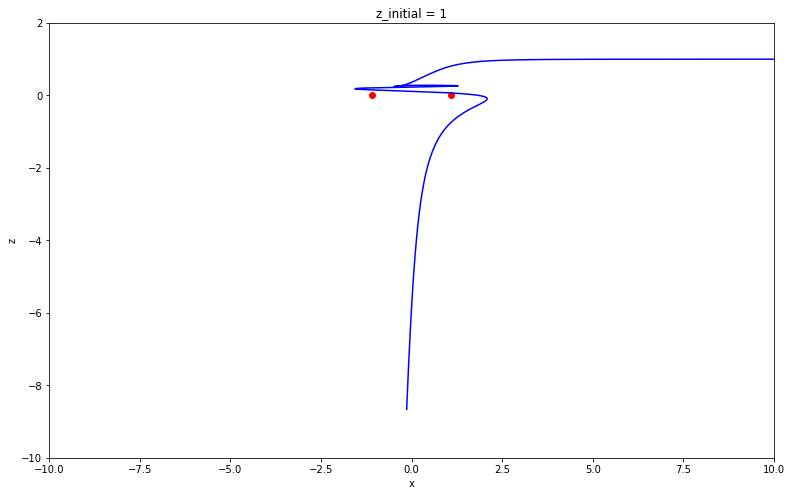

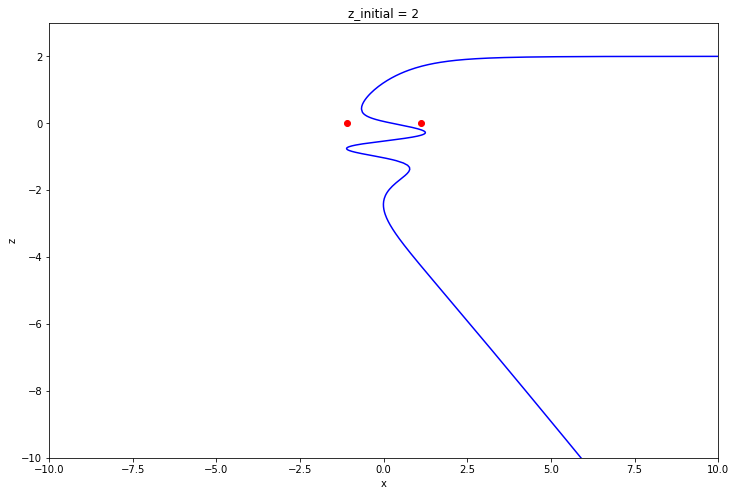

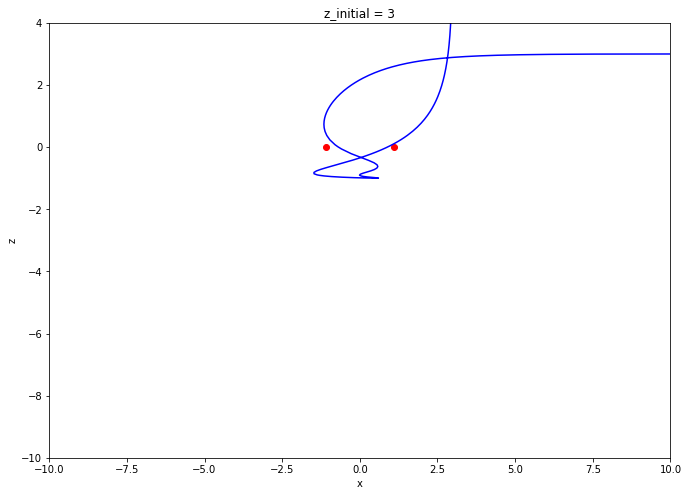

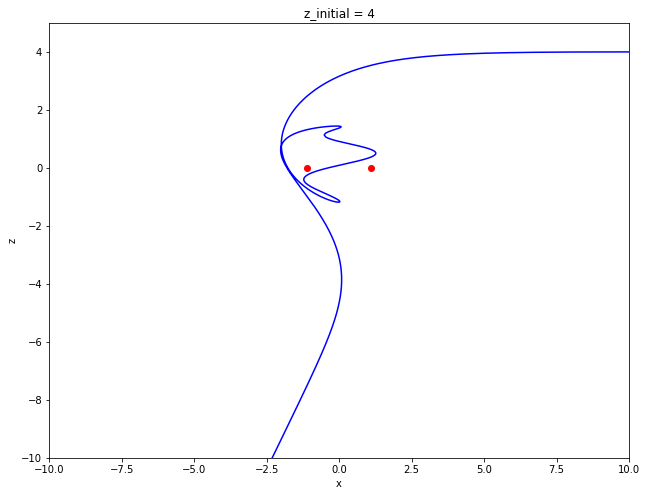

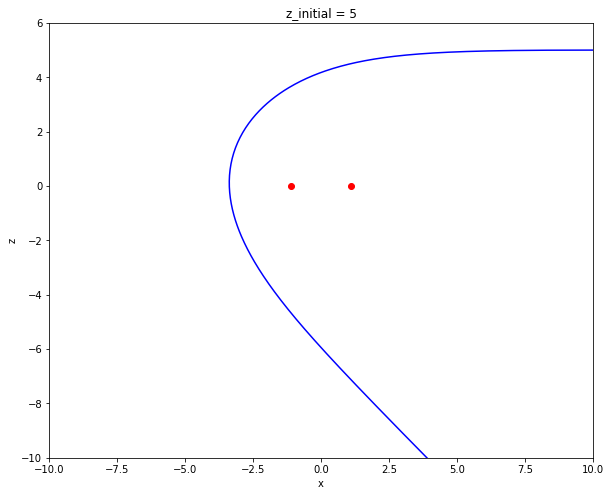

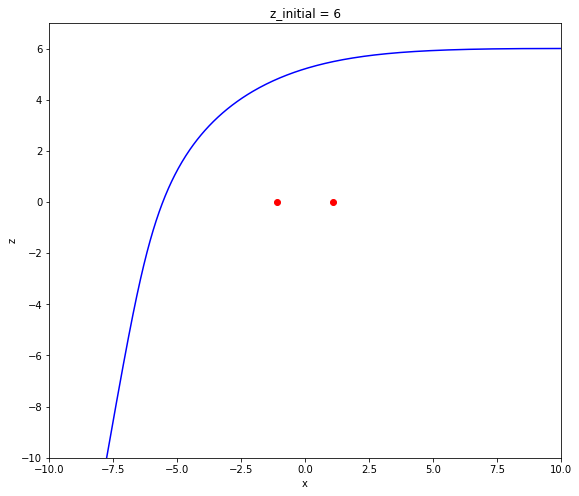

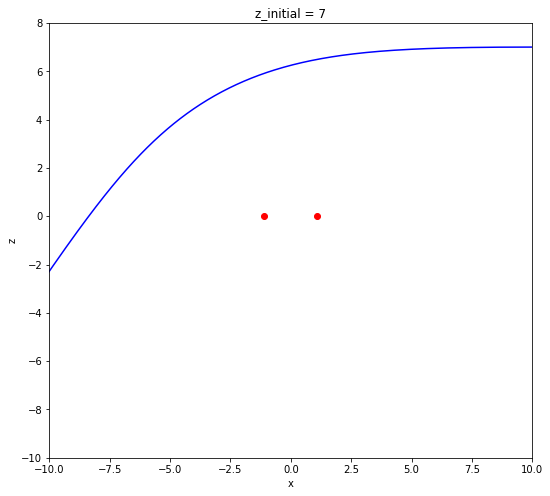

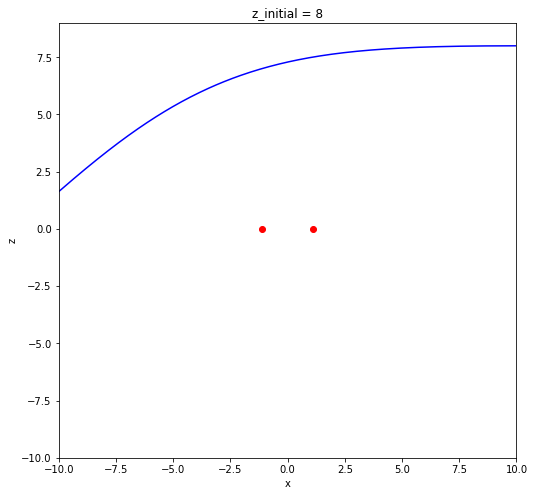

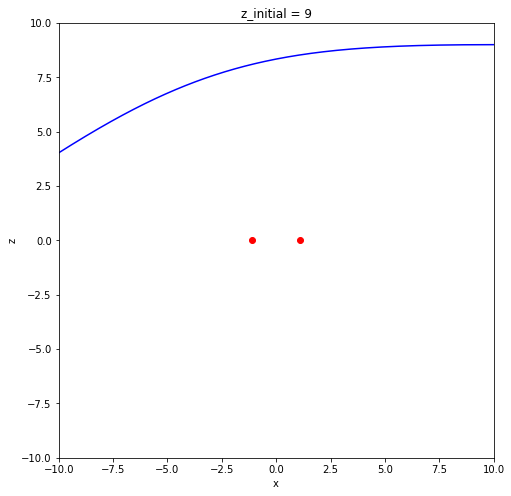

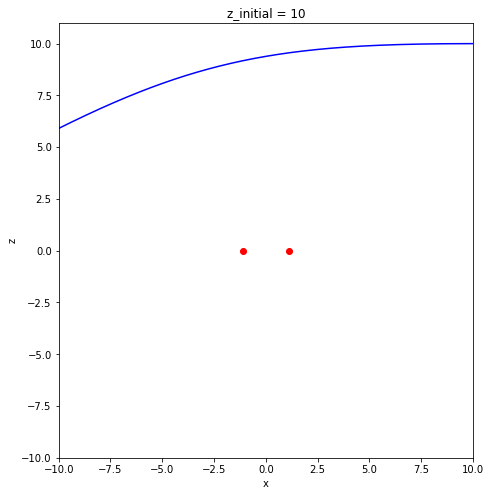

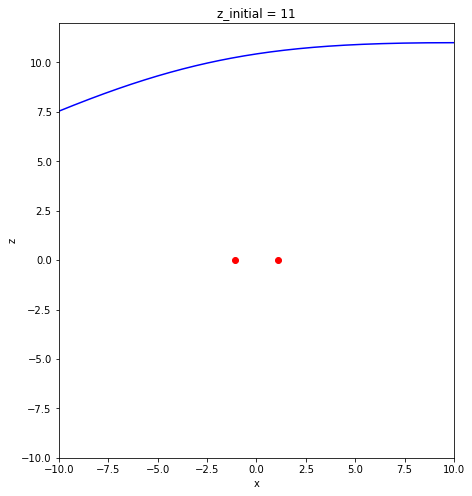

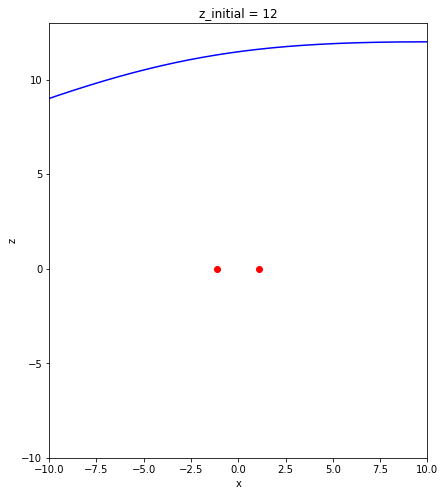

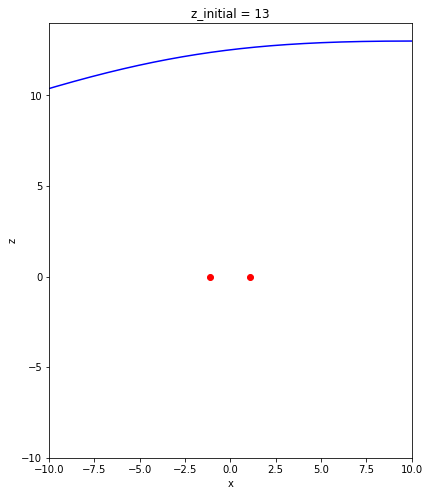

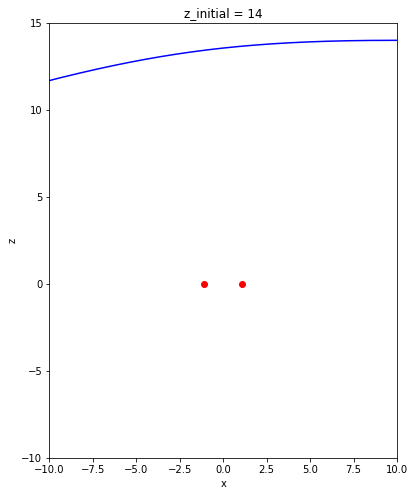

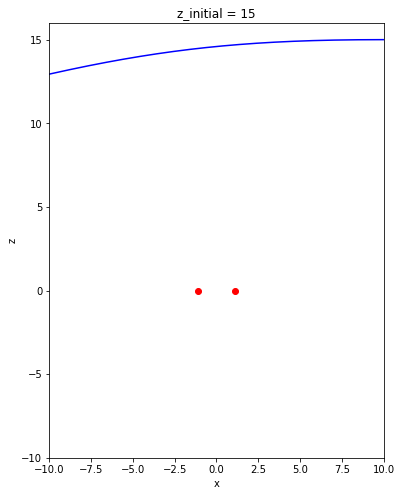

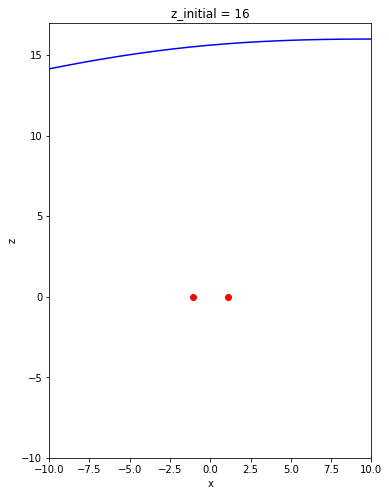

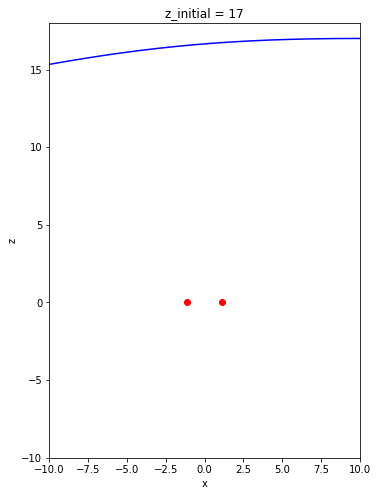

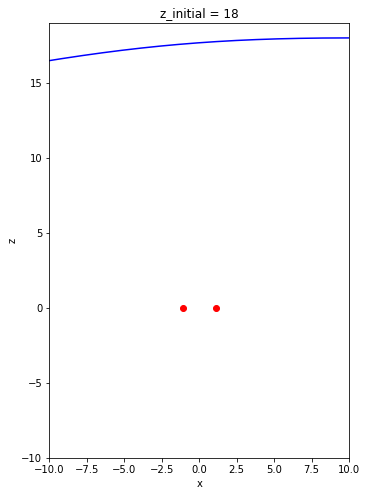

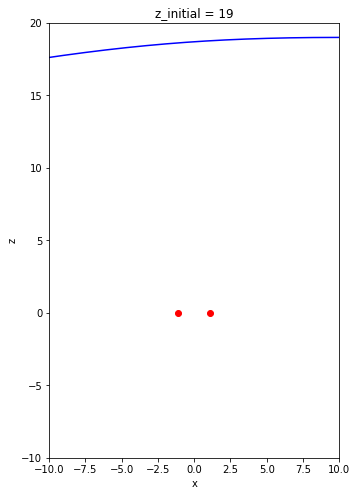

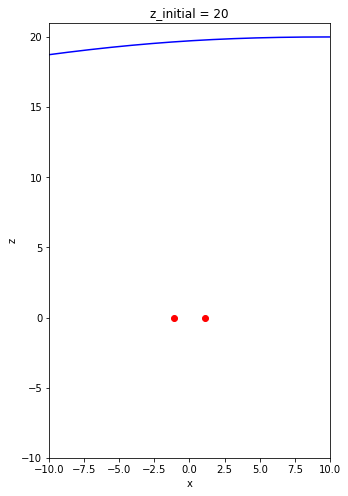

In [109]:
(theta_rad_array, theta_deg_array) = ring(1, 21)

### Graphs for z_initlal = [0, 4.8, 0.1]

<img src="z=0">

<img src="z=0.1.png">

<img src="z=0.2.png">

<img src="z=0.3.png">

<img src="z=0.4.png">

<img src="z=0.5.png">

<img src="z=0.6.png">

<img src="z=0.7.png">

<img src="z=0.8.png">

<img src="z=0.9.png">

<img src="z=1.png">

<img src="z=1.1.png">

<img src="z=1.2.png">

<img src="z=1.3.png">

<img src="z=1.4.png">

<img src="z=1.2">

<img src="z=1.6.png">

<img src="z=1.7.png">

<img src="z=1.8.png">

<img src="z=1.9.png">

<img src="z=2.png">

<img src="z=2.1.png">

<img src="z=2.2.png">

<img src="z=2.3.png">

<img src="z=2.4.png">

<img src="z=2.5.png">

<img src="z=2.6.png">

<img src="z=2.7.png">

<img src="z=2.8.png">

<img src="z=2.9.png">

<img src="z=3.png">

<img src="z=3.1.png">

<img src="z=3.2.png">

<img src="z=3.3.png">

<img src="z=3.4.png">

<img src="z=3.5.png">

<img src="z=3.6.png">

<img src="z=3.7.png">

<img src="z=3.8.png">

<img src="z=3.9.png">

<img src="z=4.png">

<img src="z=4.1.png">

<img src="z=4.2.png">

<img src="z=4.3.png">

<img src="z=4.4.png">

<img src="z=4.5.png">

<img src="z=4.6.png">

<img src="z=4.7.png">

<img src="z=4.8.png">

### Fitting the decay of theta_xyz for z = [5, 20]

Here, we plot the 3D inclination angle of the exiting photons with respect to the initial trajectory. Let's start with z = [5, 20], which shows a decay trend. Let's test if this is an exponential decay by plotting $log(\theta)$ versus $z_{initial}$. If it shows a linear relationship, that means $log(\theta) = A + Bz_i \leftrightarrow \theta = e^Ae^{(Bz_i)}$

Text(0, 0.5, 'log(theta)')

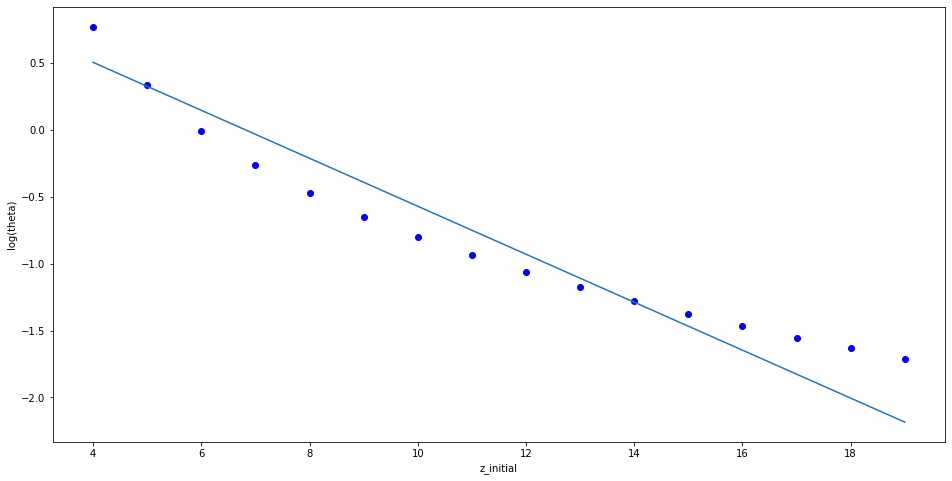

In [123]:
theta_rad_array = np.array([2.1652312, 1.39921, 0.9922832, 0.76732457, 0.623469, 0.5230041, 0.44865897, 
                           0.39136374, 0.3458543, 0.30886453, 0.27823502, 0.25248694, 0.23056833, 
                           0.2117033, 0.19531772, 0.18096499]) #theta_xyz for z = [5, 20]

fig, ax = plt.subplots(1,1,figsize=(16,8))
coefs = poly.polyfit(np.arange(4, 20), np.log(theta_rad_array), 1, w=np.sqrt(theta_rad_array))
plt.scatter(np.arange(4, 20), np.log(theta_rad_array), color = "blue")
plt.plot(np.arange(4,20), np.arange(4,20)*coefs[1] + coefs[0])
ax.set_xlabel("z_initial")
ax.set_ylabel("log(theta)")

Not quite! Let's test if it's a polynomial decay instead by plotting $log(\theta)$ versus $log(z_i)$. If it shows a linear relationship, this means $log(\theta) = A + Blog(z_i) \leftrightarrow \theta = e^A {z_i}^B$.

Text(0, 0.5, 'log(theta)')

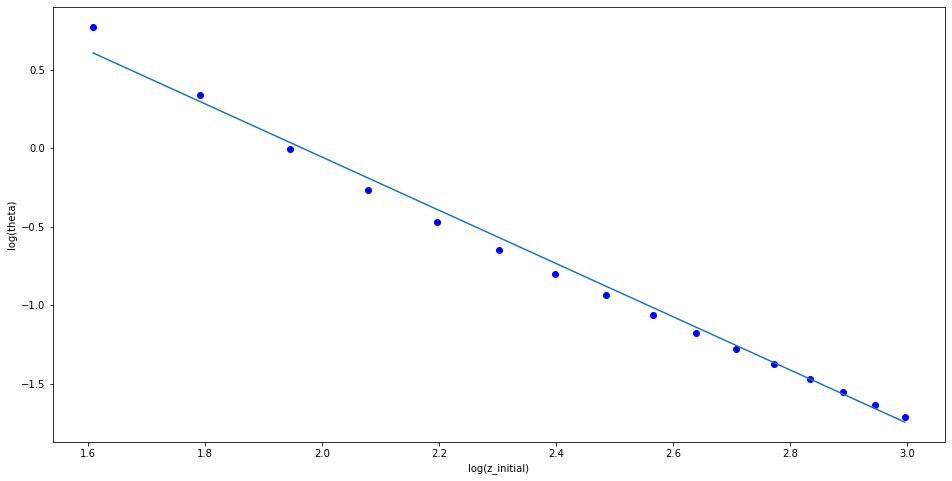

In [124]:
coefs = poly.polyfit(np.log(np.arange(5, 21)), np.log(theta_rad_array), 1, w=np.log(theta_rad_array))
fig, ax = plt.subplots(1,1,figsize=(16,8))
plt.scatter(np.log(np.arange(5, 21)), np.log(theta_rad_array), color = "blue")
plt.plot(np.log(np.arange(5,21)), np.log(np.arange(5,21))*coefs[1]+coefs[0])
ax.set_xlabel("log(z_initial)")
ax.set_ylabel("log(theta)")

In [128]:
print(coefs)
print(np.exp(coefs[0]))
# log(theta) = 3.3349886 -1.6956937log(z)
# theta = e^(3.3349886)*z^(-1.6956937) = 28.078064*z^(-1.6956937)

[ 3.3349886 -1.6956937]
28.078064


Text(0, 0.5, 'theta')

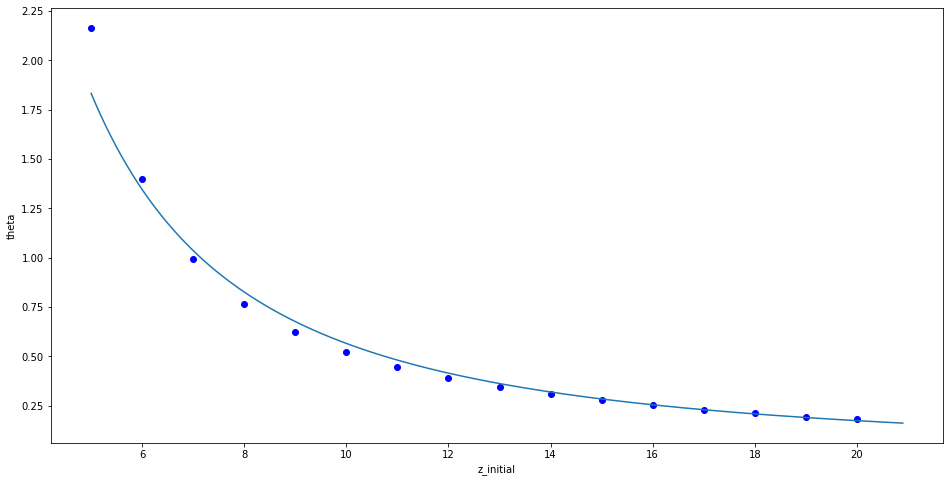

In [129]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
theta_model = np.exp(coefs[0])*np.arange(5,21,0.1)**(coefs[1])
plt.scatter(np.arange(5, 21), theta_rad_array, color = "blue")
plt.plot(np.arange(5,21,0.1), theta_model)
ax.set_xlabel("z_initial")
ax.set_ylabel("theta")

The polynomial fit $\theta = 28.078064*{z_i}^{-1.6956937}$ is better than the exponential fit.

### Fitting the decay of theta_xz for z = [5, 20]

Here, we plot the 2D inclination angle (xz-plane) of the exiting photons with respect to the initial trajectory. Let's start with z = [5, 20], which shows a decay trend. Let's test if this is an exponential decay by plotting $log(\theta)$ versus $z_{initial}$. If it shows a linear relationship, that means $log(\theta) = A + Bz_i \leftrightarrow \theta = e^Ae^{(Bz_i)}$

Text(0, 0.5, 'log(theta)')

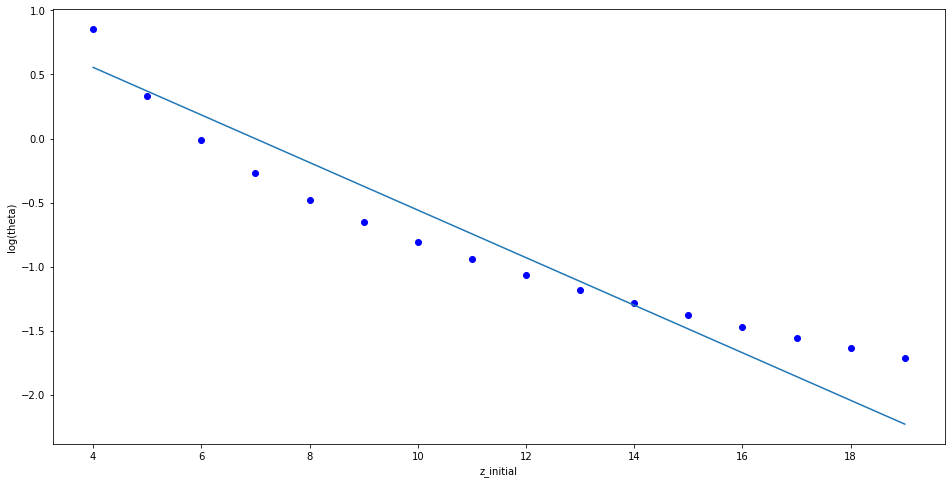

In [130]:
theta_rad_array = np.array([2.3554091, 1.3989425, 0.9888184, 0.7631729, 0.6198258,
                   0.52003515, 0.446274, 0.3894401, 0.34428763, 0.30757427, 
                   0.27716115, 0.2515837, 0.22980212, 0.2110479, 0.19475272, 0.18047519]) #theta_xz for z = [5, 20]

fig, ax = plt.subplots(1,1,figsize=(16,8))
coefs = poly.polyfit(np.arange(4, 20), np.log(theta_rad_array), 1, w=np.sqrt(theta_rad_array))
plt.scatter(np.arange(4, 20), np.log(theta_rad_array), color = "blue")
plt.plot(np.arange(4,20), np.arange(4,20)*coefs[1] + coefs[0])
ax.set_xlabel("z_initial")
ax.set_ylabel("log(theta)")

Not quite! Let's test if it's a polynomial decay instead by plotting $log(\theta)$ versus $log(z_i)$. If it shows a linear relationship, this means $log(\theta) = A + Blog(z_i) \leftrightarrow \theta = e^A {z_i}^B$.

Text(0, 0.5, 'log(theta)')

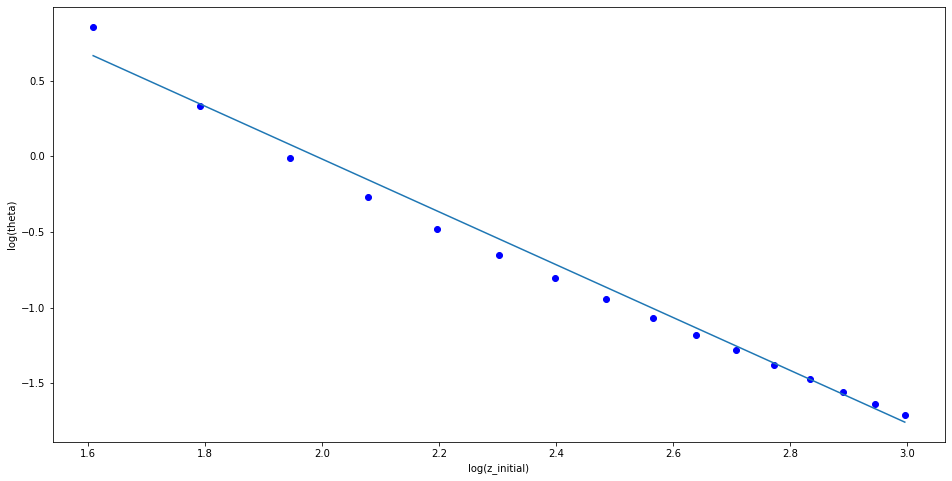

In [132]:
coefs = poly.polyfit(np.log(np.arange(5, 21)), np.log(theta_rad_array), 1, w=np.log(theta_rad_array))
fig, ax = plt.subplots(1,1,figsize=(16,8))
plt.scatter(np.log(np.arange(5, 21)), np.log(theta_rad_array), color = "blue")
plt.plot(np.log(np.arange(5,21)), np.log(np.arange(5,21))*coefs[1]+coefs[0])
ax.set_xlabel("log(z_initial)")
ax.set_ylabel("log(theta)")

In [133]:
print(coefs)
print(np.exp(coefs[0]))
# log(theta) = 3.4794524 - -1.7483428log(z)
# theta = e^(3.4794524)*z^(-1.6150725) = 32.44195*z^(-1.7483428)

[ 3.4794524 -1.7483428]
32.44195


The polynomial fit $\theta = 32.44195*{z_i}^{-1.7483428}$ is better than the exponential fit.

Text(0, 0.5, 'theta')

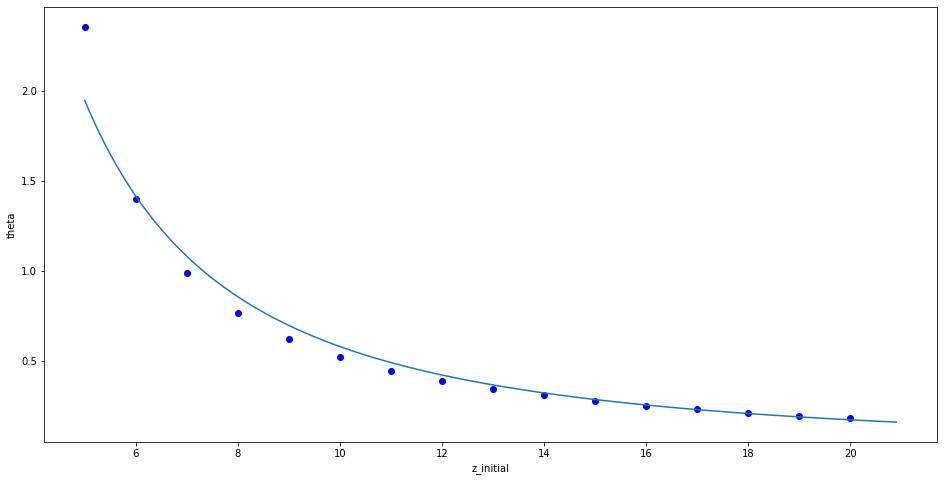

In [134]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
theta_model = np.exp(coefs[0])*np.arange(5,21,0.1)**(coefs[1])
plt.scatter(np.arange(5, 21), theta_rad_array, color = "blue")
plt.plot(np.arange(5,21,0.1), theta_model)
ax.set_xlabel("z_initial")
ax.set_ylabel("theta")

### Fitting theta_xyz for [0.1, 4.8, 0.1]

In [173]:
theta_rad_array_ = np.array([1.7838565, 1.9541155, 1.9599617, 1.9252716, 1.8733667, 1.8094243, 
                             1.7419508, 1.6720942, 1.6060532, 1.5476938, 1.5133475, 1.4920741, 
                             1.4923568, 1.5176969, 1.5678678, 1.6385487, 1.7277949, 1.8291216, 
                             1.9390745, 2.053657, 2.1677282, 2.2767012, 2.36753, 2.4232588, 
                             2.422953, 2.3562083, 2.2221482, 2.0383077, 1.8018078, 1.5445073, 
                             1.2688986, 0.97457796, 0.6842541, 0.47483915, 0.5254867, 0.8227532, 
                             1.1883236, 1.502261, 1.5862435, 1.3006817, 0.8116085, 1.0577816, 
                             2.1951802, 1.4660344, 1.9603019, 1.5969669, 1.6802918, 1.9936557]) 
#theta_xyz for z = [0.1, 4.8]

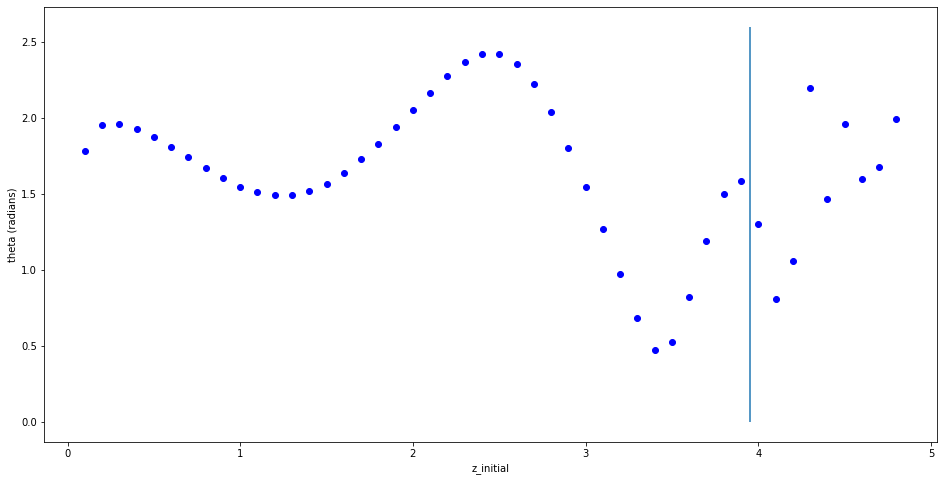

In [139]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
plt.scatter(np.arange(0.1, 4.85, 0.1), theta_rad_array_, color = "blue")

ax.set_xlabel("z_initial")
ax.set_ylabel("theta (radians)")
ax.vlines(3.95, 0, 2.6)

From z = 0 to z = 1.3, the exiting angle rotates clockwise. Then, from z = 1.3 to z = 3.9, the exiting angle rotates counter-clockwise. From z = 4 to z = 4.8, the exiting angle does not show any clear pattern. Note that $\theta$ here is confined between 0 and $\pi$ because of the arccos function, so any $\theta$ between $\pi$ and $2\pi$ is represented as $2\pi - \theta$.

/Users/nguyenquocbao/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polynomial.py:1361: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


Text(0, 0.5, 'theta (radians)')

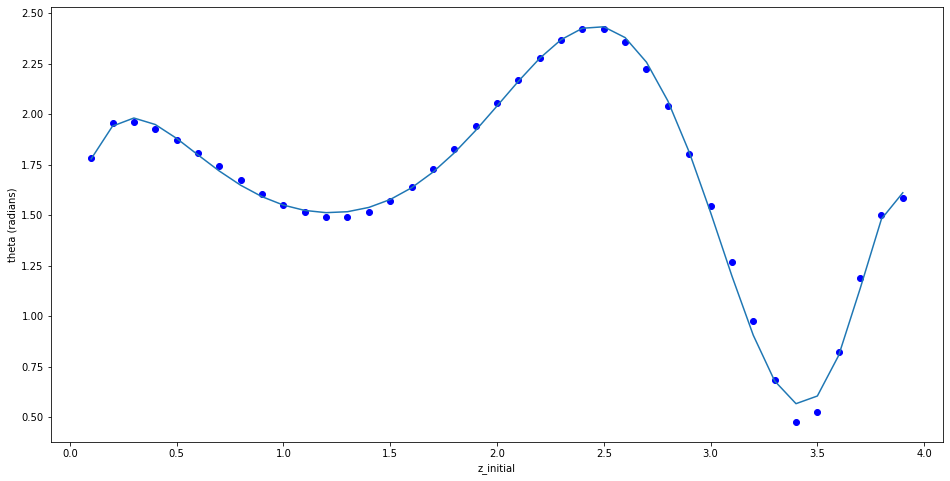

In [174]:
import numpy.polynomial.polynomial
coefs = poly.polyfit(np.arange(0.1, 4.0, 0.1), theta_rad_array_[0:39], 10)
ffit = poly.polyval(np.arange(0.1, 4.0, 0.1), coefs)
fig, ax = plt.subplots(1,1,figsize=(16,8))
plt.scatter(np.arange(0.1, 4.0, 0.1), theta_rad_array_[0:39], color = "blue")
plt.plot(np.arange(0.1, 4.0, 0.1), ffit)
ax.set_xlabel("z_initial")
ax.set_ylabel("theta (radians)")

Graphing all of them together:

Text(0, 0.5, 'theta')

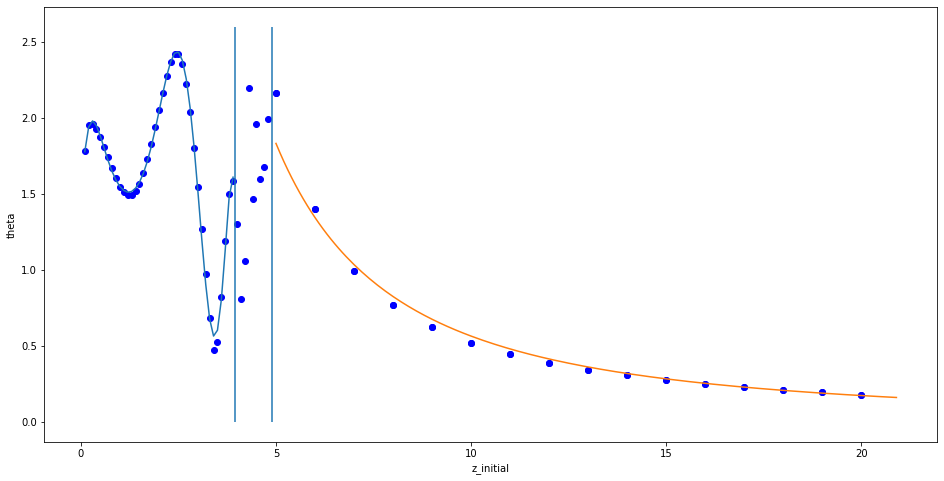

In [144]:
theta_rad_array = np.array([2.1652312, 1.39921, 0.9922832, 0.76732457, 0.623469, 0.5230041, 0.44865897, 
                           0.39136374, 0.3458543, 0.30886453, 0.27823502, 0.25248694, 0.23056833, 
                           0.2117033, 0.19531772, 0.18096499]) # theta_xyz for z = [5, 20]
theta_rad_array_all = np.concatenate((theta_rad_array_, theta_rad_array))
index = np.concatenate((np.arange(0.1, 4.85, 0.1), np.arange(5, 21)))

coefs = poly.polyfit(np.log(np.arange(5, 21)), np.log(theta_rad_array), 1, w=np.log(theta_rad_array))
theta_model = np.exp(coefs[0])*np.arange(5,21,0.1)**(coefs[1])

fig, ax = plt.subplots(1,1,figsize=(16,8))
plt.scatter(index, theta_rad_array_all, color = "blue")
ax.vlines(3.95, 0, 2.6)
plt.plot(np.arange(0.1, 4.0, 0.1), ffit)
ax.vlines(4.9, 0, 2.6)
plt.scatter(np.arange(5,21), theta_rad_array, color = "blue")
plt.plot(np.arange(5, 21, 0.1), theta_model)
ax.set_xlabel("z_initial")
ax.set_ylabel("theta")

### Fitting theta_xz for [0.1, 4.8, 0.1]

In [158]:
theta_xz = np.array([1.8284173, 2.1543653, 2.3445537, 2.4945338, 2.6863377, 
            3.048034, 2.5605829, 1.9449517, 1.6565773, 1.5436238,
            1.4897346, 1.4761065, 1.4860772, 1.516907, 1.5678847,
            1.6371131, 1.738675, 1.8685697, 2.0382416, 2.254526, 
            2.5150883, 2.8056588, 3.0947337, 2.9237173, 2.6872823, 
            2.4723947, 2.2603176, 2.0464265, 1.8022742, 1.5445063, 
            1.268802, 0.97432184, 0.67026156, 0.34810102, 0.03121501, 
            0.54348135, 1.1138479, 1.5008903, 1.587255, 1.1212614, 
            0.18984093, 1.0537872, 2.2576702, 1.4634224, 1.9617798, 
            1.5969982, 1.7654356, 3.0421202])

/Users/nguyenquocbao/anaconda3/lib/python3.7/site-packages/numpy/polynomial/polynomial.py:1361: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


Text(0, 0.5, 'theta (radians)')

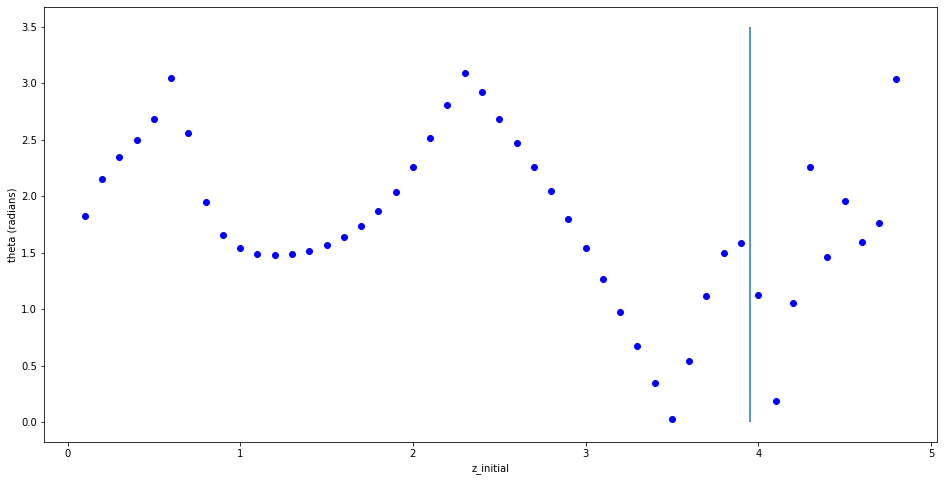

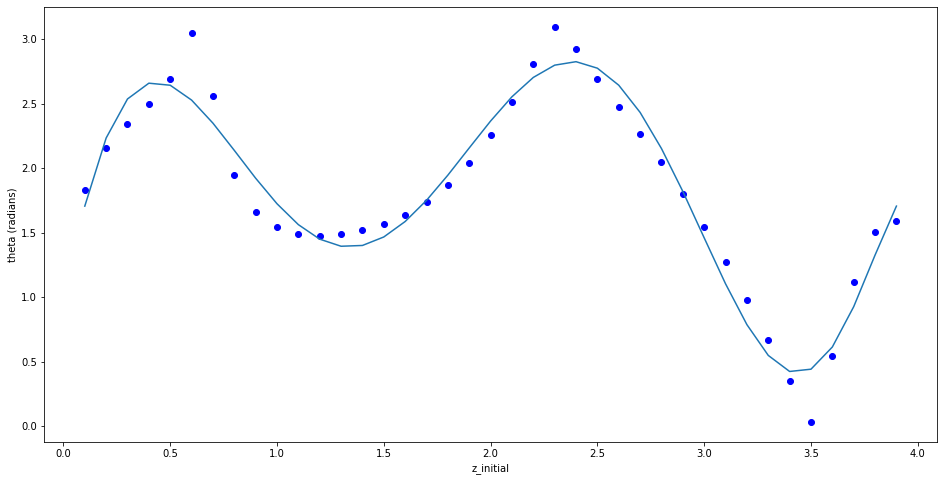

In [172]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
plt.scatter(np.arange(0.1, 4.85, 0.1), theta_xz, color = "blue")
ax.set_xlabel("z_initial")
ax.set_ylabel("theta (radians)")
ax.vlines(3.95, 0, 3.5)

coefs = poly.polyfit(np.arange(0.1, 4.0, 0.1), theta_xz[0:39], 10)
ffit = poly.polyval(np.arange(0.1, 4.0, 0.1), coefs)
fig, ax = plt.subplots(1,1,figsize=(16,8))
plt.scatter(np.arange(0.1, 4.0, 0.1), theta_xz[0:39], color = "blue")
plt.plot(np.arange(0.1, 4.0, 0.1), ffit)
ax.set_xlabel("z_initial")
ax.set_ylabel("theta (radians)")

theta_xz shows very similar behaviors compared to theta_xyz, but the pattern is much less smooth, especially at the critical point. Note that $\theta$ here is confined between 0 and $\pi$ because of the arccos function, so any $\theta$ between $\pi$ and $2\pi$ is represented as $2\pi - \theta$.

Text(0, 0.5, 'theta')

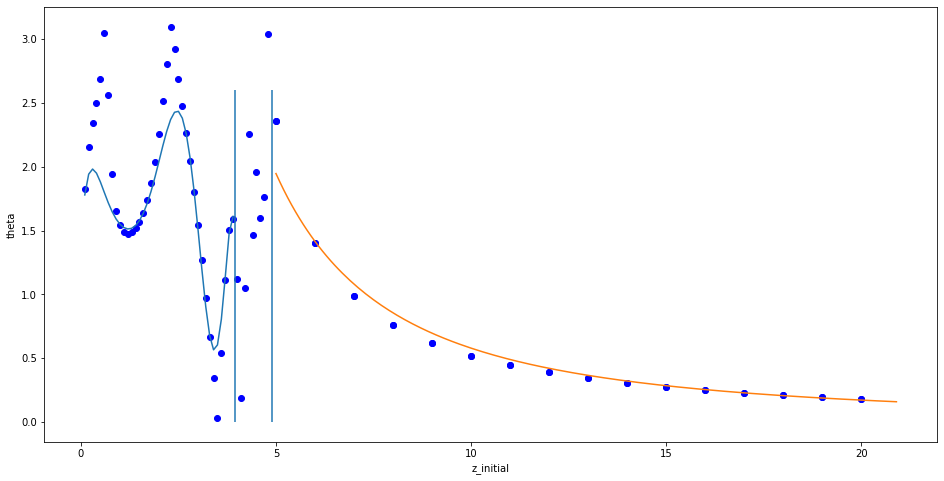

In [176]:
theta_xz_ = np.array([2.3554091, 1.3989425, 0.9888184, 0.7631729, 0.6198258,
                   0.52003515, 0.446274, 0.3894401, 0.34428763, 0.30757427, 
                   0.27716115, 0.2515837, 0.22980212, 0.2110479, 0.19475272, 0.18047519]) #theta_xz for z = [5, 20]

theta_rad_array_all = np.concatenate((theta_xz, theta_xz_))
index = np.concatenate((np.arange(0.1, 4.85, 0.1), np.arange(5, 21)))

coefs = poly.polyfit(np.log(np.arange(5, 21)), np.log(theta_xz_), 1, w=np.log(theta_xz_))
theta_model = np.exp(coefs[0])*np.arange(5,21,0.1)**(coefs[1])
_
fig, ax = plt.subplots(1,1,figsize=(16,8))
plt.scatter(index, theta_rad_array_all, color = "blue")
ax.vlines(3.95, 0, 2.6)
plt.plot(np.arange(0.1, 4.0, 0.1), ffit)
ax.vlines(4.9, 0, 2.6)
plt.scatter(np.arange(5,21), theta_xz_, color = "blue")
plt.plot(np.arange(5, 21, 0.1), theta_model)
ax.set_xlabel("z_initial")
ax.set_ylabel("theta")